**Table of contents**<a id='toc0_'></a>    
- [Programming Question](#toc1_)    
  - [Preprocessing](#toc1_1_)    
  - [Clustering](#toc1_2_)    
    - [Evaluating the clustering results](#toc1_2_1_)    
  - [Conclusion](#toc1_3_)    
- [Markdown Question](#toc2_)    
  - [Answer](#toc2_1_)    

# <a id='toc1_'></a>[Programming Question](#toc0_)

_Use PCA to reduce the dimensionality of the data to 2. You should use the dataset obtained after pre-processing and transformation from Task 1 without feature selection. Write a Python program to visualize the results of clustering the PCA-reduced dataset._

In [68]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.model_selection import ParameterGrid

In [69]:
def load_dataset() -> tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Uses np.load to load the training and test datasets used for the models in these notebooks.

    Returns:
        tuple: A tuple containing four numpy arrays representing the training and test datasets.
               The tuple elements are as follows:
               - features_train: A numpy array containing the features of the training dataset.
               - targets_train: A numpy array containing the target labels of the training dataset.
               - features_test: A numpy array containing the features of the test dataset.
               - targets_test: A numpy array containing the target labels of the test dataset.
    """    
    # Train dataset
    features_train = np.load("x_train.npy")
    targets_train = np.load("y_train.npy")
    # Test dataset
    features_test = np.load("x_test.npy")
    targets_test = np.load("y_test.npy")
    return features_train, targets_train, features_test, targets_test

In [70]:
features_train, targets_train, features_test, targets_test = load_dataset()
np.shape(features_train), np.shape(features_test)

((16200, 512), (5400, 512))

In [71]:
len(np.unique(targets_test))

10

## <a id='toc1_1_'></a>[Preprocessing](#toc0_)

This is the same process used in task1, but without feature seleciton (as per instructions). 

Explanations for the pipeline used can be found there.

This pipeline has an addition of using PCA to reduce data dimensionality to 2

In [72]:
preprocess_pipeline = Pipeline(steps = [
    ('scaler', StandardScaler()),
    ('PCA', PCA(n_components = 2))
    ]) 


In [73]:
pca_features_train = preprocess_pipeline.fit_transform(features_train)
pca_features_train

array([[-5.4048779 , -5.38019062],
       [ 1.88046019,  9.56634712],
       [ 1.78632839, -4.03123874],
       ...,
       [ 4.48678073,  4.7966835 ],
       [ 0.17442594, -3.55868876],
       [-6.03978913,  6.76712581]])

In [74]:
pca_features_test = preprocess_pipeline.transform(features_test)

## <a id='toc1_2_'></a>[Clustering](#toc0_)

To determine the best clustering method and hyperparameters are for the dataset, the following function and hyperparameter combinations were made. The aim of this is to compare the silhouette score of each combination explored, and to use the best one. 

Silhouette score is a metric for evaluating clustering results. This score measures how well a dataset is clustered by measuring within-cluster similarity and out-of-cluster discrimination.Ranges from -1 (incorrect clustering) to +1 (high-density clustering), with 0 indicating overlapping clusters.

In [75]:
def evaluate_clustering(params: list[dict[str, any]]) -> dict[str, any]:
    """Evaluate clustering algorithms with different parameters and select the best one based on silhouette score.

    Args:
        params (list[dict[str, any]]): A list of dictionaries containing parameters for clustering algorithms.

    Returns:
        dict[str, any]: The best parameters along with the silhouette score and the clustering method.
    """
    best_score = -1
    best_params = None
    for i in params:
        kmeans = KMeans(**i)
        kmeans.fit(pca_features_train)
        clusters_test = kmeans.predict(pca_features_test)
        silhouette_kmeans = silhouette_score(pca_features_test, clusters_test)
        minikmeans = MiniBatchKMeans(**i)
        minikmeans.fit(pca_features_train)
        clusters_test = minikmeans.predict(pca_features_test)
        silhouette_minik = silhouette_score(pca_features_test, clusters_test)
        if silhouette_kmeans > silhouette_minik:
            if silhouette_kmeans > best_score:
                best_score = silhouette_kmeans
                best_params = i
                best_params['score'] = silhouette_kmeans
                best_params['method'] = 'kmeans'
        elif silhouette_minik > silhouette_kmeans:
            if silhouette_minik > best_score:
                best_score = silhouette_minik
                best_params = i
                best_params['score'] = silhouette_minik
                best_params['method'] = 'mini batch kmeans'
    return best_params

In [76]:
# Hyperparameters to explore
params = {
    'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'init': ['k-means++', 'random'],
    'max_iter': [100, 200, 300],
    'tol': [1e-4, 1e-3, 1e-2],
    'random_state': [30]
}
params = list(ParameterGrid(params)) 

In [77]:
best_params = evaluate_clustering(params)
best_params

{'init': 'random',
 'max_iter': 100,
 'n_clusters': 3,
 'random_state': 30,
 'tol': 0.01,
 'score': 0.4260173837153885,
 'method': 'kmeans'}

In [78]:
best_params.pop('score')
best_params.pop('method')

'kmeans'

Based on these results, the best method of clustering is with KMeans, using the above parameters.

In [79]:
km = KMeans(**best_params)
km.fit(pca_features_train)
clusters_test = km.predict(pca_features_test)

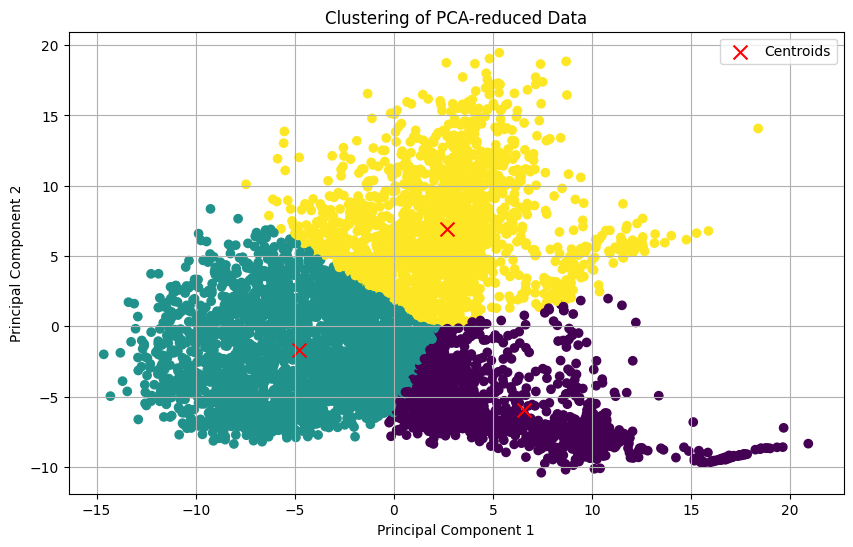

In [80]:
# Visualise the clustering results
plt.figure(figsize=(10, 6))

# Plot data points with colors representing clusters
plt.scatter(pca_features_test[:, 0], pca_features_test[:, 1], c=clusters_test, cmap='viridis')

# Plot centroids of each cluster
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], c='red', marker='x', s=100, label='Centroids')

plt.title('Clustering of PCA-reduced Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()

### <a id='toc1_2_1_'></a>[Evaluating the clustering results](#toc0_)

In addition to silhouette score, Davies-Bouldin Score and Calinski-Harabasz Score will be used to evaluate the performance of the chosen clustering method. These can be defined as:

* Davies-Bouldin Score
  * The average similarity between each cluster and its most similar cluster. Lower values indicate better clustering, with 0 indicating perfectly separated clusters.
* Calinski-Harabasz Score
  * Ratio of the sum of between-clusters dispersion and within-cluster dispersion for all clusters. Higher values indicate better clustering, with high scores meaning dense and well-separated clusters.

In [81]:
# Calculate the clustering results
silhouette_avg = silhouette_score(pca_features_test, clusters_test)
davies_bouldin = davies_bouldin_score(pca_features_test, clusters_test)
calinski_harabasz = calinski_harabasz_score(pca_features_test, clusters_test)

print(f'Silhouette Score: {silhouette_avg}')
print(f'Davies-Bouldin Score: {davies_bouldin}')
print(f'Calinski-Harabasz Score: {calinski_harabasz}')


Silhouette Score: 0.4260173837153885
Davies-Bouldin Score: 0.7915538853999199
Calinski-Harabasz Score: 4956.307970939541


These results indicate a reasonable level of clustering quality. The Silhouette Score of 0.426 suggests reasonably well-separated clusters. Davies-Bouldin of 0.782 is a relatively low score (low values indicate better clustering). 

However, the Calinski-Harabasz Score of 4956.32 is quite high, suggesting dense and well-separated clusters, as higher values indicate better-defined clusters. 

Overall, these scores suggest that the clustering algorithm has produced somewhat well-defined and separated clusters, but there is room for improvement.

## <a id='toc1_3_'></a>[Conclusion](#toc0_)

After applying required pre-processing techniques and using PCA to reduce data dimensionality to 2, evaluation of clustering methods was performed. When the most suitable clustering method was determined, results were visualised and the chosen method was evaluated further.

# <a id='toc2_'></a>[Markdown Question](#toc0_)

_How do you think the visualization will change if you used 3 PCA components? (150 words)_

## <a id='toc2_1_'></a>[Answer](#toc0_)

Using 3 PCA components instead of 2 would result in the plotted points needing to be in 3D space, instead of 2D space.
 
Exploring additional dimensions of the data could result in increased complexity in interpretation of the visualisation, as discerning the clusters visually may be harder. An example being when there is overlap between clusters or if the clusters are not well-separated in the higher-dimensional space. 

The visualisation could provide a more detailed understanding of the data, as more distinct clusters can be generated if there are patterns in the data best captured in three dimensions.  More variance in the data can potentially be observed.

In addition, a different number of clusters may be generated than was with 2 PCA components. The extra dimension in the data could alter the silhouette scores when exploring hyperparameters to the point where a different number of clusters are generated.
